# 前準備

In [1]:
%%capture
!pip install linearmodels

In [2]:
import hashlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from scipy import stats
from statsmodels.iolib.summary2 import summary_col
from tqdm import tqdm

URL_LENTA_DATA = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/lenta_dataset.csv"
URL_CLUSTER_TRIAL = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_cluster_trial.csv"
URL_STRATIFIED_TRIAL = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_stratified_trial.csv"
URL_AATEST = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_aatest_trial.csv"
URL_NONCOMPLIANCE = "https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch3_noncompliance_abtest.csv"

# A/Bテストについての発展的な話題

## A/Aテスト：A/Bテスト設計の妥当性を確認する
### プログラム3.1 割当単位と分析単位が不一致な場合の回帰分析

書籍上では次のようなコードになっています。
```python
import pandas as pd
import statsmodels.formula.api as smf

df_cluster_trial = pd.read_csv(URL_CLUSTER_TRIAL)
result = smf.ols(
    formula="is_click ~ is_treatment", data=df_cluster_trial
).fit()
result.summary().tables[1]
```

In [3]:
df_cluster_trial = pd.read_csv(URL_CLUSTER_TRIAL)
result = smf.ols(
    formula="is_click ~ is_treatment", data=df_cluster_trial
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5216,0.008,69.521,0.000,0.507,0.536
is_treatment,-0.0232,0.010,-2.365,0.018,-0.043,-0.004


In [4]:
df_cluster_trial

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


### プログラム3.2 A/A テストの分析（A/A テストが成功しているとき）
書籍上では次のようなコードになっています。

```python
df_aatest = pd.read_csv(URL_AATEST)
result = smf.ols(
    formula="is_click~is_treatment", data=df_aatest
).fit()
result.summary().tables[1]
```

In [5]:
df_aatest = pd.read_csv(URL_AATEST)
result = smf.ols(
    formula="is_click~is_treatment", data=df_aatest
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4988,0.007,70.327,0.000,0.485,0.513
is_treatment,0.0102,0.010,1.015,0.310,-0.009,0.030


In [6]:
df_aatest

,imp_id,is_treatment,is_click
0,0,1,0
1,1,1,0
2,2,1,1
3,3,0,1
4,4,0,1
...,...,...,...
9995,9995,1,1
9996,9996,1,1
9997,9997,0,1
9998,9998,1,0


### プログラム3.3 A/A テストのリプレイ

書籍上では次のようなコードになっています。
```python
import hashlib

import numpy as np
from tqdm import tqdm

def assign_treatment_randomly(imp_id, salt):
    return (
        int(hashlib.sha256(f"{salt}_{imp_id}".encode()).hexdigest(), 16)
        % 2
    )


# セットアップ
df_aatest = pd.read_csv(URL_AATEST)
rng = np.random.default_rng(seed=0)
replays = []
# for-loopによる繰り返し処理
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f"salt{i}"
    df_aatest["is_treatment_in_aa"] = df_aatest["imp_id"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_aatest
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)
```

In [7]:
def assign_treatment_randomly(imp_id, salt):
    return (
        int(hashlib.sha256(f"{salt}_{imp_id}".encode()).hexdigest(), 16)
        % 2
    )


# セットアップ
df_aatest = pd.read_csv(URL_AATEST)
rng = np.random.default_rng(seed=0)
replays = []
# for-loopによる繰り返し処理
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f"salt{i}"
    df_aatest["is_treatment_in_aa"] = df_aatest["imp_id"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_aatest
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 26.04it/s]


### プログラム3.4 A/A テストのリプレイの可視化
本文では次のようになっています。
```python
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()
```

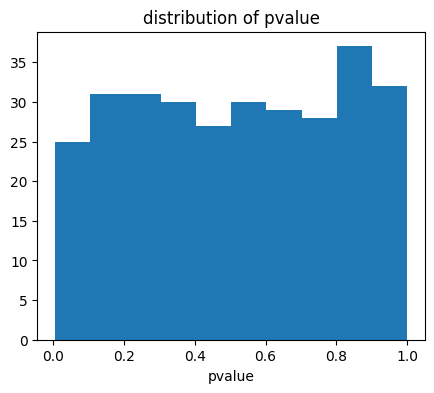

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()

### プログラム3.5 コルモゴロフ─スミルノフ検定による分布の確認
本文では次のようになっています。
``` python
from scipy import stats

stats.kstest(replays, "uniform", args=(0, 1))
```

In [9]:
stats.kstest(replays, "uniform", args=(0, 1))

KstestResult(statistic=0.04504551195892681, pvalue=0.5611215508935568, statistic_location=0.6883788452922601, statistic_sign=-1)

## 状況に応じたA/Bテストのモデリング

### クラスターA/BテストCluster A/B Test 

#### プログラム3.6 クラスターA/B テストデータにおけるA/A テストのリプレイ

本文では次のようになっています。
```python
def assign_treatment_randomly(uid, salt):
    return (
        int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16)
        % 2
    )


df_cluster = pd.read_csv(URL_CLUSTER_TRIAL)
rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f"salt{i}"
    df_cluster["is_treatment_in_aa"] = df_cluster["uid"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_cluster
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)
```

In [10]:
def assign_treatment_randomly(uid, salt):
    return (
        int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16)
        % 2
    )


df_cluster = pd.read_csv(URL_CLUSTER_TRIAL)
rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f"salt{i}"
    df_cluster["is_treatment_in_aa"] = df_cluster["uid"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 擬似的な割当の下での分析
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_cluster
    ).fit()
    pvalue = result.pvalues["is_treatment_in_aa"]
    # 情報の格納
    replays.append(pvalue)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.53it/s]


In [11]:
df_cluster

,uid,is_treatment,is_click,is_treatment_in_aa
0,0,0,1,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
10635,199,1,0,0
10636,199,1,0,0
10637,199,1,1,0
10638,199,1,0,0


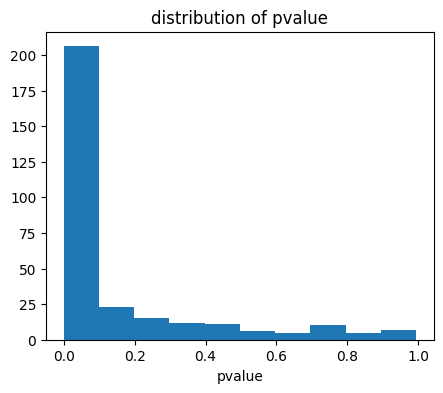

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()

In [13]:
stats.kstest(replays, "uniform", args=(0, 1))

KstestResult(statistic=0.6134127868406709, pvalue=4.70019809957193e-109, statistic_location=0.056587213159329075, statistic_sign=1)

#### プログラム3.7 クラスターA/B テストデータの分析
本書では次のようなコードになっています
```python
df_cluster_trial = pd.read_csv(URL_CLUSTER_TRIAL)
# 施策効果の推定
result = smf.ols(
    formula="is_click ~ is_treatment", data=df_cluster_trial
).fit()
# クラスター頑健標準誤差を用いて分析する
result_corrected = result.get_robustcov_results(
    "cluster", groups=df_cluster_trial["uid"]
)
result_corrected.summary().tables[1]
```

In [14]:
df_cluster_trial = pd.read_csv(URL_CLUSTER_TRIAL)
# 施策効果の推定
result = smf.ols(
    formula="is_click ~ is_treatment", data=df_cluster_trial
).fit()
# クラスター頑健標準誤差を用いて分析する
result_corrected = result.get_robustcov_results(
    "cluster", groups=df_cluster_trial["uid"]
)
result_corrected.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5216,0.033,15.632,0.000,0.456,0.587
is_treatment,-0.0232,0.043,-0.539,0.590,-0.108,0.062


In [15]:
df_cluster_trial

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


#### プログラム3.8 クラスターA/BテストデータのA/Aテスト

``` python
def assign_treatment_randomly(uid, salt):
    return (
        int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16)
        % 2
    )


rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割り当て    
    salt = f"salt{i}"
    df_cluster["is_treatment_in_aa"] = df_cluster["uid"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 分析    
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_cluster
    ).fit()
    result_corrected = result.get_robustcov_results(
        "cluster", groups=df_cluster["uid"]
    )
    pvalue = result_corrected.pvalues[
        result_corrected.model.exog_names.index("is_treatment_in_aa")
    ]
    # 情報の格納    
    replays.append(pvalue)
```

In [16]:
def assign_treatment_randomly(uid, salt):
    return (
        int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16)
        % 2
    )


rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割り当て
    salt = f"salt{i}"
    df_cluster["is_treatment_in_aa"] = df_cluster["uid"].apply(
        assign_treatment_randomly, salt=salt
    )
    # 分析
    result = smf.ols(
        formula="is_click ~ is_treatment_in_aa", data=df_cluster
    ).fit()
    result_corrected = result.get_robustcov_results(
        "cluster", groups=df_cluster["uid"]
    )
    pvalue = result_corrected.pvalues[
        result_corrected.model.exog_names.index("is_treatment_in_aa")
    ]
    # 情報の格納
    replays.append(pvalue)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 21.67it/s]


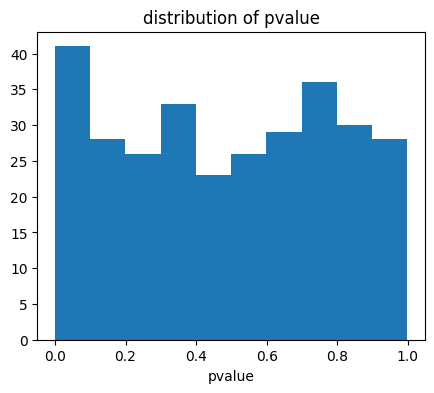

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.set_facecolor("none")
ax.set_xlabel("pvalue")
ax.set_title("distribution of pvalue")
plt.show()

In [18]:
# 本文には掲載していない
stats.kstest(replays, "uniform", args=(0, 1))

KstestResult(statistic=0.04319182166835675, pvalue=0.6145727388836066, statistic_location=0.08347484499830993, statistic_sign=1)

### 層化A/Bテスト Stratified A/B Test

#### プログラム3.9 シミュレーション：ランダムな割り当てをした場合の性別割合の偏り
本文では次のように掲載しています。
``` python
rng = np.random.default_rng(seed=0)
ratio = [
    rng.choice([0, 1], p=[0.5, 0.5], size=500).mean()
    for _ in range(100)
]
plt.hist(ratio)
plt.xlabel("male ratio")
plt.ylabel("frequency")
plt.show()
```

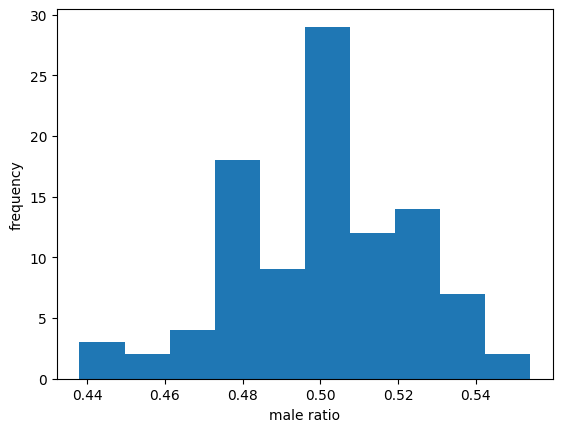

In [19]:
rng = np.random.default_rng(seed=0)
ratio = [
    rng.choice([0, 1], p=[0.5, 0.5], size=500).mean()
    for _ in range(100)
]
plt.hist(ratio)
plt.xlabel("male ratio")
plt.ylabel("frequency")
plt.show()

#### プログラム3.10 層化A/B テストにおけるランダムな割り当て
本文では次のように掲載しています。

``` python
import seaborn as sns

def assign_strata(df_group, ratio_treat, rng, column_name):
    num_samples = round(len(df_group) * ratio_treat)
    df_group[column_name] = 0
    treat_indices = rng.choice(
        df_group.index, num_samples, replace=False
    )
    df_group.loc[treat_indices, column_name] = 1
    return df_group


# データの読み込み
df_titanic = sns.load_dataset("titanic")[
    ["survived", "sex", "pclass"]
]
# groupbyメソッドを用いて無作為抽出
rng = np.random.default_rng(11)
df_titanic_assigned = df_titanic.groupby(
    ["sex", "pclass"], group_keys=False
).apply(
    assign_strata, ratio_treat=0.3, column_name="is_treat", rng=rng
)
```

In [20]:
def assign_strata(df_group, ratio_treat, rng, column_name):
    num_samples = round(len(df_group) * ratio_treat)
    df_group[column_name] = 0
    treat_indices = rng.choice(
        df_group.index, num_samples, replace=False
    )
    df_group.loc[treat_indices, column_name] = 1
    return df_group


# データの読み込み
df_titanic = sns.load_dataset("titanic")[
    ["survived", "sex", "pclass"]
]
# groupbyメソッドを用いて無作為抽出
rng = np.random.default_rng(11)
df_titanic_assigned = df_titanic.groupby(
    ["sex", "pclass"], group_keys=False
).apply(
    assign_strata, ratio_treat=0.3, column_name="is_treat", rng=rng
)

In [21]:
df_titanic_assigned

,survived,sex,pclass,is_treat
0,0,male,3,0
1,1,female,1,0
2,1,female,3,1
3,1,female,1,0
4,0,male,3,0
...,...,...,...,...
886,0,male,2,1
887,1,female,1,0
888,0,female,3,0
889,1,male,1,0


#### プログラム3.11　サブグループごとの割当比率を確認する

In [22]:
df_titanic_assigned.groupby(["sex", "pclass"])["is_treat"].mean()

sex     pclass
female  1         0.297872
        2         0.302632
        3         0.298611
male    1         0.303279
        2         0.296296
        3         0.299712
Name: is_treat, dtype: float64

#### 層化A/Bテストの分析の実装

#### プログラム3.12 層化A/B テストの分析（通常のA/B テストと同様に行った場合）
本書では次のように掲載しています。
``` python
df_stratified = pd.read_csv(URL_STRATIFIED_TRIAL)
# 分析
result = smf.ols(formula="y ~ is_treatment", data=df_stratified).fit()
result.summary().tables[1]
```

In [23]:
df_stratified = pd.read_csv(URL_STRATIFIED_TRIAL)
# 分析
result = smf.ols(formula="y ~ is_treatment", data=df_stratified).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.9951,0.332,-18.036,0.000,-6.654,-5.336
is_treatment,0.5530,0.468,1.182,0.240,-0.375,1.481


In [24]:
df_stratified

,is_treatment,group_name,y
0,0,0,-7.094851
1,0,0,-2.853676
2,1,0,-3.024156
3,1,0,-4.989469
4,1,0,-2.724840
...,...,...,...
104,0,1,-9.971287
105,1,1,-10.593688
106,1,1,-6.990840
107,0,1,-7.833720


#### プログラム3.13 層化 A/B テストの分析（ダミー変数を利用した場合）
``` python
result = smf.ols(
    formula="y ~ is_treatment + C(group_name)", data=df_stratified
).fit()
result.summary().tables[1]
```

In [25]:
result = smf.ols(
    formula="y ~ is_treatment + C(group_name)", data=df_stratified
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.7373,0.141,-33.649,0.000,-5.016,-4.458
C(group_name)[T.1],-5.2247,0.216,-24.182,0.000,-5.653,-4.796
is_treatment,0.5301,0.184,2.878,0.005,0.165,0.895


## 処置と割当の不一致 A/B テストにおける Non-compliance
#### プログラム3.14 施策意図の効果の分析：Intent to Treat
本文では次のように掲載しています。
``` python
df_noncompliance = pd.read_csv(URL_NONCOMPLIANCE)
# Intent to Treatの分析
result = smf.ols(
    formula="purchase ~ assignment", data=df_noncompliance
).fit()
result.summary().tables[1]
```

In [26]:
df_noncompliance = pd.read_csv(URL_NONCOMPLIANCE)
# Intent to Treatの分析
result = smf.ols(
    formula="purchase ~ assignment", data=df_noncompliance
).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9918.2820,64.690,153.321,0.000,9791.338,1e+04
assignment,197.0536,92.320,2.134,0.033,15.890,378.217


In [27]:
df_noncompliance

,assignment,x,is_deliver,purchase
0,0.0,0.017286,0.0,10563.182011
1,1.0,-0.037921,1.0,8861.781424
2,1.0,0.056103,0.0,11450.231477
3,1.0,-0.213583,0.0,8357.833101
4,0.0,0.023237,0.0,10755.016507
...,...,...,...,...
995,0.0,-0.082353,0.0,9127.673875
996,0.0,-0.108672,0.0,9919.530298
997,1.0,-0.125113,0.0,9469.139734
998,1.0,0.140215,1.0,11103.908090


#### プログラム3.15 平均的な開封割合の確認

In [28]:
df_noncompliance.groupby("assignment")["is_deliver"].mean()

assignment
0.0    0.000000
1.0    0.450102
Name: is_deliver, dtype: float64

####  プログラム3.16 操作変数法の2段階推定による施策効果を復元する分析
本文では次のように掲載しています。

``` python
from linearmodels.iv import IV2SLS

# 操作変数法の2段階推定
iv = IV2SLS.from_formula(
    formula="purchase ~ 1 + [is_deliver ~ assignment] + x",
    data=df_noncompliance,
).fit()
iv.summary.tables[1]
```

In [29]:
# 操作変数法の2段階推定
iv = IV2SLS.from_formula(
    formula="purchase ~ 1 + [is_deliver ~ assignment] + x",
    data=df_noncompliance,
).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,9943.6,42.853,232.04,0.0000,9859.6,1.003e+04
x,9714.6,290.72,33.416,0.0000,9144.8,1.028e+04
is_deliver,533.98,141.26,3.7802,0.0002,257.12,810.84


first stage確認

In [30]:
iv.first_stage

,is_deliver
R-squared,0.3018
Partial R-squared,0.2977
Shea's R-squared,0.2977
Partial F-statistic,408.62
P-value (Partial F-stat),0.0000
Partial F-stat Distn,chi2(1)
==========================,==========
Intercept,0.0009
,(0.5299)
x,0.3463


# 共変量を入れて分析をする
#### プログラム3.17 共変量を考慮したA/B テストの分析
本文では次のように記していました。
``` python
df_abtest = pd.read_csv(URL_LENTA_DATA)
result_with_covariates = smf.ols(
    formula="response_att ~ is_treatment + food_share_15d + age + is_women",
    data=df_abtest,
).fit()
result_with_covariates.summary().tables[1]
```

In [31]:
df_abtest = pd.read_csv(URL_LENTA_DATA)
result_with_covariates = smf.ols(
    formula="response_att ~ is_treatment + food_share_15d + age + is_women",
    data=df_abtest,
).fit()
result_with_covariates.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0539,0.005,10.555,0.000,0.044,0.064
is_treatment,0.0072,0.003,2.285,0.022,0.001,0.013
food_share_15d,0.1713,0.003,51.131,0.000,0.165,0.178
age,-0.0003,9.3e-05,-3.047,0.002,-0.000,-0.000
is_women,0.0033,0.003,1.157,0.247,-0.002,0.009


In [32]:
df_abtest

,is_treatment,response_att,food_share_15d,age,is_women
0,1,0,0.0000,33.0,1
1,0,0,0.0000,63.0,1
2,1,0,0.0000,51.0,1
3,0,0,0.0000,38.0,1
4,1,0,0.5105,20.0,1
...,...,...,...,...,...
49995,1,0,0.0000,60.0,1
49996,0,0,0.0000,26.0,0
49997,1,0,0.8461,28.0,1
49998,1,0,0.0000,19.0,1


- A/Bテストの結果再掲

In [33]:
result_plain = smf.ols(
    formula="response_att ~ is_treatment ", data=df_abtest
).fit()
result_plain.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1024,0.003,36.412,0.000,0.097,0.108
is_treatment,0.0091,0.003,2.809,0.005,0.003,0.015


# 施策効果の異質性 ~ どこで効果があるのか知る

#### プログラム3.18 サブサンプル分割による異質性の分析

``` python
from statsmodels.iolib.summary2 import summary_col

# サブサンプル分割
df_abtest = pd.read_csv(URL_LENTA_DATA)
df_men = df_abtest.loc[df_abtest["is_women"] == 0, :]
df_women = df_abtest.loc[df_abtest["is_women"] == 1, :]
# 推定（is_women = 0）
result_men = smf.ols(
    formula="response_att ~ is_treatment", data=df_men
).fit()
# 推定（is_women = 1）
result_women = smf.ols(
    formula="response_att ~ is_treatment", data=df_women
).fit()
# 推定した結果をまとめて表示
summary_col(
    [result_men, result_women],
    model_names=("only men model", "only women model"),
    stars=False,
)
```

In [34]:
# サブサンプル分割
df_abtest = pd.read_csv(URL_LENTA_DATA)
df_men = df_abtest.loc[df_abtest["is_women"] == 0, :]
df_women = df_abtest.loc[df_abtest["is_women"] == 1, :]
# 推定（is_women = 0）
result_men = smf.ols(
    formula="response_att ~ is_treatment", data=df_men
).fit()
# 推定（is_women = 1）
result_women = smf.ols(
    formula="response_att ~ is_treatment", data=df_women
).fit()
# 推定した結果をまとめて表示
summary_col(
    [result_men, result_women],
    model_names=("only men model", "only women model"),
    stars=False,
)

,only men model,only women model
Intercept,0.1010,0.1032
,(0.0046),(0.0036)
is_treatment,0.0135,0.0065
,(0.0053),(0.0041)
R-squared,0.0003,0.0001
R-squared Adj.,0.0003,0.0000


In [35]:
result_men.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.021,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.543,0.011,0.003,0.024


In [36]:
result_women.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1032,0.004,29.006,0.000,0.096,0.110
is_treatment,0.0065,0.004,1.583,0.113,-0.002,0.014


In [37]:
# ダミー変数であるis_womenカラムの中身を確認する
df_abtest[["is_women"]]

,is_women
0,1
1,1
2,1
3,1
4,1
...,...
49995,1
49996,0
49997,1
49998,1


#### プログラム3.19 交差項による異質性の分析
本文では次のように記載しています。
``` python
df_abtest = pd.read_csv(URL_LENTA_DATA)
# 推定
result_hetero = smf.ols(
    formula="response_att ~ is_treatment + is_women + is_treatment * is_women",
    data=df_abtest,
).fit()
# 推定結果の表示
result_hetero.summary().tables[1]
```

In [38]:
df_abtest = pd.read_csv(URL_LENTA_DATA)
# 推定
result_hetero = smf.ols(
    formula="response_att ~ is_treatment + is_women + is_treatment * is_women",
    data=df_abtest,
).fit()
# 推定結果の表示
result_hetero.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.184,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.562,0.010,0.003,0.024
is_women,0.0022,0.006,0.380,0.704,-0.009,0.014
is_treatment:is_women,-0.0070,0.007,-1.050,0.294,-0.020,0.006
